## Cycle GAN in PyTorch

In [3]:
%load_ext autoreload
%matplotlib inline

In [10]:
%autoreload 2

from IPython import display

from utils import Logger

import os, urllib, zipfile, itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

### Download data

In [11]:
DATA_FOLDER = './torch_data/CycleGAN'

In [12]:
VALID_DATA_NAMES = ["ae_photos", "apple2orange", "summer2winter_yosemite", "horse2zebra", "monet2photo", "cezanne2photo", "ukiyoe2photo", "vangogh2photo", "maps", "cityscapes","facades","iphone2dslr_flower","mini", "mini_pix2pix", "mini_colorization"]

URL = 'https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{}.zip'
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def rename_images(rootdir):
    for subdir, dirs, files in os.walk(rootdir):
        idx = 0
        for file in files:
            file_path = os.path.join(subdir, file)
            new_file_path = os.path.join(subdir, "{}.jpg".format(idx))
            os.rename(file_path, new_file_path)
            idx = idx + 1
        
def download_cyclegan_dataset(filename, path, force=False):
    # Validate dataset filename is valid.
    assert(filename in VALID_DATA_NAMES)
    # Return if path exists.
    file_path = "{}/{}.zip".format(path, filename)
    if os.path.exists(file_path) and not force: return
    # Otherwise download.
    
    # Make path directory if missing.
    os.makedirs(path, exist_ok=True)
    # Download data
    url = URL.format(filename)
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, file_path, reporthook=t.update_to)
        with zipfile.ZipFile(file_path, 'r') as zip_obj:
            zip_obj.extractall(path)
    rename_images(os.path.join(path, filename))

In [13]:
for name in VALID_DATA_NAMES:
    download_cyclegan_dataset(name, DATA_FOLDER, force=False)

### Create Dataset Class

In [14]:
from torch.utils.data import Dataset
from PIL import Image
from skimage import io
import torch
import torch.nn as nn
import torch.nn.functional as F

class CycleGanDataset(Dataset):
    """My dataset."""
    
    def __init__(self, path, transform=None):
        self._path = path
        self.num_files = len(os.listdir(self._path))
        self.transform = transform

    def __len__(self):
        return self.num_files
    
    def filename(self, idx):
        for directory in ["trainA", "testA"]:
            possible_path = os.path.join(self._path, directory, "{}.jpg".format(str(idx)))
            if os.path.exists(possible_path):
                return possible_path

    def __getitem__(self, idx):
        # Handle vectors.
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.filename(idx)
        print(img_name)
        image = Image.fromarray(io.imread(img_name))
        if self.transform:
            image = self.transform(image)
        return image

    def visualize(self, idx):
        np_img = np.transpose(self[idx].numpy(), (1,2, 0))
        plt.imshow(np_img)

### Load Data

In [15]:
def load_cyclegan_dataset():
    compose = transforms.Compose(
        [transforms.Resize((80, 80)),
         transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
    return CycleGanDataset(DATA_FOLDER + "/ae_photos", transform=compose)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./torch_data/CycleGAN/ae_photos/testA/101.jpg
./torch_data/CycleGAN/ae_photos/testA/101.jpg


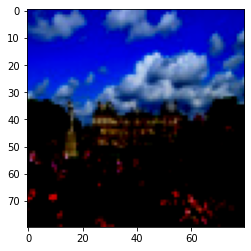

In [16]:
data_A = load_cyclegan_dataset()
data_B = load_cyclegan_dataset()

# Safety check visualization.
data_A.visualize(101)
data_B.visualize(101)

#### Discriminator 

In [17]:
class DiscriminatorNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        self.conv_0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,
                                   kernel_size=(4, 4), stride=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                                   kernel_size=(4, 4), stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                                   kernel_size=(4, 4), stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,
                                   kernel_size=(4, 4), stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_out = nn.Conv2d(in_channels=512, out_channels=1,
                             kernel_size=(4, 4), stride=2)
    
    def forward(self, x):
        x = self.conv_0(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_out(x)

In [18]:
Dis_a = DiscriminatorNet()
Dis_b = DiscriminatorNet()

### Generator net

In [19]:
class GeneratorNet(torch.nn.Module):
    
    def __init__(self):
        super(GeneratorNet, self).__init__()
        
        # c7s1-64
        self.conv_0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=1, 
                      padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # d128
        self.conv_1 = nn.Sequential( 
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2,
                      padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # d256
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=2,
                     padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # R256
        self.res_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # R256
        self.res_4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # R256
        self.res_5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # R256
        self.res_6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # R256
        self.res_7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # R256
        self.res_8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # u128
        self.ups_9 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, 
                               kernel_size=(3, 3), stride=0.5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        # u64
        self.ups_10 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), 
                               stride=0.5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # c7s1-3
        self.conv_0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(7, 7), stride=1, 
                      padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
    # TODO(diegoalejogm): Add skip layer connections.    
    def forward(self, x):
        x = self.conv_0(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.res_3(x)
        x = self.res_4(x)
        x = self.res_5(x)
        x = self.res_6(x)
        x = self.res_7(x)
        x = self.res_8(x)
        x = self.ups_9(x)
        x = self.ups_10(x)
        x = self.conv_11(x)
        return x
        

In [20]:
Gen_a2b = GeneratorNet()
Gen_b2a = GeneratorNet()

## Optimization

#### CUDA

In [22]:
loss = nn.BCELoss()
gan_loss_f = nn.MSELoss()
cycle_loss_f = nn.L1Loss()

g_optimizer = torch.optim.Adam(itertools.chain(Gen_a2b.parameters(), Gen_b2a.parameters()), lr=0.0002, betas=(0.5, 0.999))

d_optimizer = torch.optim.Adam(itertools.chain(Dis_a.parameters(), Dis_b.parameters()), lr=0.0002, betas=(0.5, 0.999))

In [23]:
def real_data_label(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_label(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [24]:
def train_generator(gan_loss_f, cycle_loss_f, 
                    generator_a2b, generator_b2a, 
                    real_data, fake_data, lambd):
    
    def adversarial_loss(loss_fn, fake_data):
        # Calculate loss for D(G(x)), x being a "fake" sample, treating it as positive.
        prediction = discriminator(fake_data)
        return loss_fn(prediction, real_data_label(fake_data.size(0)))
    
    def cycle_loss(loss_fn, lambd, generator_first, generator_second, real_data):
        # Calculate loss for cycle F(G(x)), compared to `real_data` sample.
        fake_data = generator_first(real_data)
        recons_data = generator_second(fake_data)
        return loss_fn(recons, recons_data) * lambd
    
    optimizer.zero_grad()

    # Calculate adversarial loss for each generator.
    gen_A_loss = adversarial_loss()
    gen_B_loss = adversarial_loss()
    
    # Calculate Cycle consistency loss for generators in each domain (A, B).
    cycle_loss_A = cycle_loss()
    cycle_loss_B = cycle_loss()
    
    # Compute full generator loss.
    gen_full_loss = (
        (gen_A_loss + gen_B_loss) + # Generator loss 
        (cycle_loss_A + cycle_loss_B) # Cycle consistency loss
    )

    # Back propagate the loss.
    gen_full_loss.backward()
    g_optimizer.step()

In [25]:
def train_discriminator():
    
    def adversarial_loss(loss_fn, discriminator, real_data, fake_data):
        # Calculate loss for D(G(x)), x being a "fake" sample.
        prediction = discriminator(fake_data)
        loss_fake_data = loss_fn(prediction, fake_data_label(fake_data.size(0)))
        
        # Calculate loss for D(G(x)), x being a "real" sample.
        prediction_real = discriminator(real_data)
        loss_real_data = loss_fn(prediction, real_data_label(real_data.size(0)))
        
        return loss_fake_data + loss_real_data
    
    optimizer.zero_grad()
    
    # Compute adversarial loss for each discriminator.
    disc_A_loss = adversarial_loss()
    disc_B_loss = adversarial_loss()
    
    # Compute full discriminator loss.
    disc_full_loss = disc_A_loss + disc_B_loss

    # Backward propagate.
    disc_full_loss.backward()
    optimizer.step()

In [26]:
# num_epochs = 100

# for epoch in range(num_epochs):
# for i, (a_real, b_real) in enumerate(zip(data_A, data_B)):
#     a_real = Variable(a_real[0])
#     b_real = Variable(b_real[0])
#     a_real, b_real = utils.cuda([a_real, b_real])

#     a_fake = self.G_b2a(b_real)
#     b_fake = self.G_a2b(a_real)
    

IndentationError: expected an indented block (<ipython-input-26-90b6f5a53e4d>, line 4)